Forward algorithm: P(observation sequence) = 1.135978e-03
Viterbi most likely hidden states: ['Sunny', 'Rainy', 'Rainy', 'Sunny', 'Sunny', 'Sunny']
Viterbi path probability (max) = 1.567642e-04


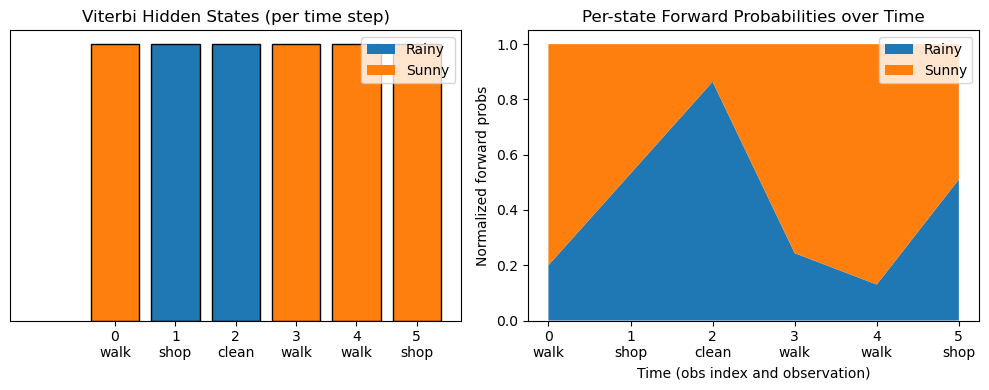


Alpha (forward probs) per timestep (unnormalized):
t=0 (walk): ['6.000000e-02', '2.400000e-01']
t=1 (shop): ['5.520000e-02', '4.860000e-02']
t=2 (clean): ['2.904000e-02', '4.572000e-03']
t=3 (walk): ['2.215680e-03', '6.873120e-03']
t=4 (walk): ['4.300224e-04', '2.873146e-03']
t=5 (shop): ['5.801096e-04', '5.558682e-04']


In [1]:
# HMM: Forward algorithm + Viterbi algorithm + simple visualizations
import numpy as np
import matplotlib.pyplot as plt

# ------------------------
# HMM definition (toy example)
# ------------------------
states = ["Rainy", "Sunny"]
n_states = len(states)

observations = ["walk", "shop", "clean"]
n_obs = len(observations)

# initial probabilities (pi)
pi = np.array([0.6, 0.4])  # P(state at t=0)

# transition probability matrix A: A[i,j] = P(state_j | state_i)
A = np.array(
    [
        [0.7, 0.3],  # Rainy -> rainy,sunny
        [0.4, 0.6],  # Sunny -> rainy,sunny
    ]
)

# emission probability matrix B: B[i,k] = P(obs_k | state_i)
B = np.array(
    [
        [0.1, 0.4, 0.5],  # Rainy emits walk,shop,clean
        [0.6, 0.3, 0.1],  # Sunny emits walk,shop,clean
    ]
)

# Example observation sequence (as strings) and convert to indices
obs_seq = ["walk", "shop", "clean", "walk", "walk", "shop"]
obs_idx = [observations.index(o) for o in obs_seq]
T = len(obs_idx)


# ------------------------
# Forward algorithm (alpha)
# ------------------------
def forward(pi, A, B, obs_idx):
    T = len(obs_idx)
    n_states = A.shape[0]
    alpha = np.zeros((T, n_states))
    # t = 0 (initialization)
    alpha[0, :] = pi * B[:, obs_idx[0]]
    # recursion
    for t in range(1, T):
        for j in range(n_states):
            alpha[t, j] = B[j, obs_idx[t]] * np.sum(alpha[t - 1, :] * A[:, j])
    # sequence probability
    seq_prob = np.sum(alpha[-1, :])
    return alpha, seq_prob


alpha, seq_prob = forward(pi, A, B, obs_idx)
print(f"Forward algorithm: P(observation sequence) = {seq_prob:.6e}")


# ------------------------
# Viterbi algorithm
# ------------------------
def viterbi(pi, A, B, obs_idx):
    T = len(obs_idx)
    n_states = A.shape[0]
    delta = np.zeros(
        (T, n_states)
    )  # max prob of any path that ends in state j at time t
    psi = np.zeros((T, n_states), dtype=int)  # argmax backpointers

    # initialization
    delta[0, :] = pi * B[:, obs_idx[0]]
    psi[0, :] = 0

    # recursion
    for t in range(1, T):
        for j in range(n_states):
            probs = delta[t - 1, :] * A[:, j]
            psi[t, j] = np.argmax(probs)
            delta[t, j] = np.max(probs) * B[j, obs_idx[t]]

    # termination
    path = np.zeros(T, dtype=int)
    path[T - 1] = np.argmax(delta[T - 1, :])
    # backtracking
    for t in range(T - 2, -1, -1):
        path[t] = psi[t + 1, path[t + 1]]

    path_states = [states[s] for s in path]
    path_prob = np.max(delta[-1, :])
    return path, path_states, path_prob, delta


v_path_idx, v_path_states, v_prob, delta = viterbi(pi, A, B, obs_idx)
print("Viterbi most likely hidden states:", v_path_states)
print(f"Viterbi path probability (max) = {v_prob:.6e}")

# ------------------------
# Simple visualizations
# 1) Viterbi path as colored bar (state assignment over time)
# 2) Forward probabilities over time (stacked area)
# ------------------------
time = np.arange(T)

# Map states to integers/colors
state_to_int = {s: i for i, s in enumerate(states)}
v_path_int = v_path_idx

# Colors
cmap = plt.get_cmap("tab10")
state_colors = [cmap(i) for i in range(n_states)]

plt.figure(figsize=(10, 4))

# (A) Viterbi state bar
plt.subplot(1, 2, 1)
for t in range(T):
    plt.bar(t, 1.0, color=state_colors[v_path_int[t]], edgecolor="k")
plt.xticks(time, [f"{t}\n{obs_seq[t]}" for t in time])
plt.yticks([])
plt.title("Viterbi Hidden States (per time step)")
# legend
for i, s in enumerate(states):
    plt.bar(-1, 0, color=state_colors[i], label=s)  # dummy for legend
plt.legend(loc="upper right")

# (B) Forward probabilities (normalized alpha -> posterior approx when combined w backward)
# Normalize alpha per timestep for visualization (alpha_sum -> 1)
alpha_norm = alpha / (alpha.sum(axis=1, keepdims=True) + 1e-12)

plt.subplot(1, 2, 2)
plt.stackplot(time, alpha_norm.T, labels=states)
plt.xticks(time, [f"{t}\n{obs_seq[t]}" for t in time])
plt.xlabel("Time (obs index and observation)")
plt.ylabel("Normalized forward probs")
plt.title("Per-state Forward Probabilities over Time")
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

# ------------------------
# (Optional) Print alpha table for inspection
# ------------------------
print("\nAlpha (forward probs) per timestep (unnormalized):")
for t in range(T):
    print(f"t={t} ({obs_seq[t]}):", ["{:.6e}".format(x) for x in alpha[t]])
